# Build Sequence Model

Before running this model, be sure to copy activity data, train_data_names.csv, core.py, datasets_colab.py

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Wed Jun  9 20:07:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    75W / 149W |      0MiB / 11441MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
              

In [2]:
import multiprocessing
n_cpus = multiprocessing.cpu_count()
print(n_cpus)

4


In [3]:
!pip install -U --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn
!pip install optuna
!pip install plotnine
!pip install gpplot

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [4]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.base import clone
from sklearn.metrics import r2_score
import optuna
import numpy as np
from tensorflow import keras


from datetime import datetime

from datasets import dataset_list
from core import (get_predictive_performance,
                  plot_spearman_heatmap,
                  plot_model_performance,
                  setup_plots)

In [5]:
setup_plots()

In [6]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

In [7]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()

## Cross-Validation Iterator

In [8]:
sg_df_list = []
for ds in train_data_list:
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

Context sequences with multiple targets: 0


In [9]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])
                      .reset_index(drop=True))
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
tidy_cv_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(sg_df_class_groups, sg_df_class_groups.dataset,
                                                         sg_df_class_groups.target)):
    train_df = sg_df_class_groups.iloc[train_index,:].copy()
    train_df['cv'] = i
    train_df['train'] = True
    tidy_cv_list.append(train_df)
    test_df = sg_df_class_groups.iloc[test_index,:].copy()
    test_df['cv'] = i
    test_df['train'] = False
    tidy_cv_list.append(test_df)
tidy_cv_df = pd.concat(tidy_cv_list)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
cv_train_data_counts

,cv,train,dataset,n
0,3,True,Kim2019_train,10939
1,4,True,Kim2019_train,10613
2,0,True,Kim2019_train,9958
3,1,True,Kim2019_train,9956
4,2,True,Kim2019_train,9862
5,0,True,Xiang2021,9183
6,1,True,Xiang2021,9137
7,4,True,Xiang2021,9137
8,2,True,Xiang2021,9068
9,3,True,Xiang2021,9063


## Keras Convolutional Neural Network

In [10]:
def get_cnn(n_conv_layers, filters_per_conv, filter_len,
            nodes_per_dense, dense_dropout_rate, n_dense_layers=1,
            input_shape=(30, 4), activation='relu', initializer='he_uniform',
            pool_size=2, loss='mse', optimizer='Adam'):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for _ in range(n_conv_layers):
        model.add(keras.layers.Conv1D(filters=filters_per_conv, kernel_size=filter_len,
                                      activation=activation, kernel_initializer=initializer))
        model.add(keras.layers.AveragePooling1D(pool_size=pool_size))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(dense_dropout_rate))
    for _ in range(n_dense_layers):
        model.add(keras.layers.Dense(nodes_per_dense, activation=activation, kernel_initializer=initializer))
        model.add(keras.layers.Dropout(dense_dropout_rate))
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(loss=loss, optimizer=optimizer)
    return model


nt_codes = {'A':[1,0,0,0],
            'C':[0,1,0,0],
            'G':[0,0,1,0],
            'T':[0,0,0,1]}

def encode_seqs(seqs):
    # 3d array with samples x position x nt
    encoded_seqs = np.array([[nt_codes.get(x) for x in seq] for seq in seqs])
    return encoded_seqs


def cnn_training_iteration(fold_df, train_index, test_index, base_model):
    """Train cnn model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param test_index: list-like
    :param base_model: KerasRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_val_seqs = train_df['sgRNA Context Sequence'] # train and validation data
    y_train_val = train_df['sgRNA Activity']
    train_seqs, val_seqs, y_train, y_val = train_test_split(train_val_seqs, y_train_val,
                                                            test_size=0.1, random_state=7)
    X_train = encode_seqs(train_seqs)
    X_val = encode_seqs(val_seqs)
    model = clone(base_model)
    model.fit(X_train, y_train, verbose=0, validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=20)])
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    X_test = encode_seqs(test_df['sgRNA Context Sequence'])
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
    return r2


def get_cnn_objective(fold_df):
    """Get objective function for training a cnn model

    :param fold_df: DataFrame
    :return: objective function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for cnn

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        n_conv_layers = trial.suggest_int('n_conv_layers', 1, 2)
        filters_per_conv = trial.suggest_int('filters_per_conv', 32, 256)
        filter_len = trial.suggest_int('filter_len', 2, 8)
        nodes_per_dense = trial.suggest_int('nodes_per_dense', 8, 256)
        dense_dropout_rate = trial.suggest_float('dense_dropout_rate', 0.1, 0.5)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=get_cnn, epochs=5000,
                                                           n_conv_layers=n_conv_layers,
                                                           filters_per_conv=filters_per_conv,
                                                           filter_len=filter_len,
                                                           nodes_per_dense=nodes_per_dense,
                                                           dense_dropout_rate=dense_dropout_rate)
        performance = [cnn_training_iteration(fold_df, train_index, test_index, model) for
                       train_index, test_index in
                       sgkf.split(fold_df, fold_df.dataset, fold_df.target)]
        avg_performance = np.mean(performance)
        return avg_performance
    return objective

In [11]:
n_trials = 1
cnn_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
    objective = get_cnn_objective(fold_train_data)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    train_df = fold_train_data.copy()
    train_val_seqs = train_df['sgRNA Context Sequence'] # train and validation data
    y_train_val = train_df['sgRNA Activity']
    train_seqs, val_seqs, y_train, y_val = train_test_split(train_val_seqs, y_train_val,
                                                            test_size=0.1, random_state=7)
    X_train = encode_seqs(train_seqs)
    X_val = encode_seqs(val_seqs)
    model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=get_cnn, epochs=5000,
                                                       **trial.params)
    model.fit(X_train, y_train, verbose=0, validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=20)])
    # Test optimal model on test data
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = encode_seqs(fold_test_data['sgRNA Context Sequence'])
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = 'All + CNN + TPE' + str(n_trials)
    test_predictions['fold'] = fold
    cnn_prediction_list.append(test_predictions)

[I 2021-06-09 20:08:22,623] A new study created in memory with name: no-name-8b44b10c-d6a3-43db-9400-3803c9d0fa31


Fold: 0


[I 2021-06-09 20:13:58,465] Trial 0 finished with value: 0.5250804070262731 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.5250804070262731.


Number of finished trials: 1
Training Time: 0:05:35.842376
Best trial:
  Value: 0.5250804070262731
  Params: 
    n_conv_layers: 1
    filters_per_conv: 207
    filter_len: 5
    nodes_per_dense: 188
    dense_dropout_rate: 0.4911958047986411


[I 2021-06-09 20:15:26,487] A new study created in memory with name: no-name-b930a227-90bb-4c3f-8e91-7329250b061e


Fold: 1


[I 2021-06-09 20:20:27,051] Trial 0 finished with value: 0.5187316023593428 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.5187316023593428.


Number of finished trials: 1
Training Time: 0:05:00.562596
Best trial:
  Value: 0.5187316023593428
  Params: 
    n_conv_layers: 1
    filters_per_conv: 207
    filter_len: 5
    nodes_per_dense: 188
    dense_dropout_rate: 0.4911958047986411


[I 2021-06-09 20:21:40,951] A new study created in memory with name: no-name-cef72bda-ee1c-4829-bae1-1113e74cf712


Fold: 2


[I 2021-06-09 20:27:15,774] Trial 0 finished with value: 0.5191937553269865 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.5191937553269865.


Number of finished trials: 1
Training Time: 0:05:34.822012
Best trial:
  Value: 0.5191937553269865
  Params: 
    n_conv_layers: 1
    filters_per_conv: 207
    filter_len: 5
    nodes_per_dense: 188
    dense_dropout_rate: 0.4911958047986411


[I 2021-06-09 20:28:41,354] A new study created in memory with name: no-name-d14e5c23-6075-4026-88d9-95dbafd3efd7


Fold: 3


[I 2021-06-09 20:34:14,506] Trial 0 finished with value: 0.5009464647968371 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.5009464647968371.


Number of finished trials: 1
Training Time: 0:05:33.150922
Best trial:
  Value: 0.5009464647968371
  Params: 
    n_conv_layers: 1
    filters_per_conv: 207
    filter_len: 5
    nodes_per_dense: 188
    dense_dropout_rate: 0.4911958047986411


[I 2021-06-09 20:35:14,727] A new study created in memory with name: no-name-d5c561f2-aa02-48df-845a-eda58d5b7320


Fold: 4


[I 2021-06-09 20:41:10,787] Trial 0 finished with value: 0.5175578594028131 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.5175578594028131.


Number of finished trials: 1
Training Time: 0:05:56.059011
Best trial:
  Value: 0.5175578594028131
  Params: 
    n_conv_layers: 1
    filters_per_conv: 207
    filter_len: 5
    nodes_per_dense: 188
    dense_dropout_rate: 0.4911958047986411


In [12]:
cnn_predictive_performance, cnn_agg_performance = get_predictive_performance(cnn_prediction_list,
                                                                             'sgRNA Activity')

In [13]:
cnn_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All + CNN + TPE1,0.649535,0.11622,0.642843


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


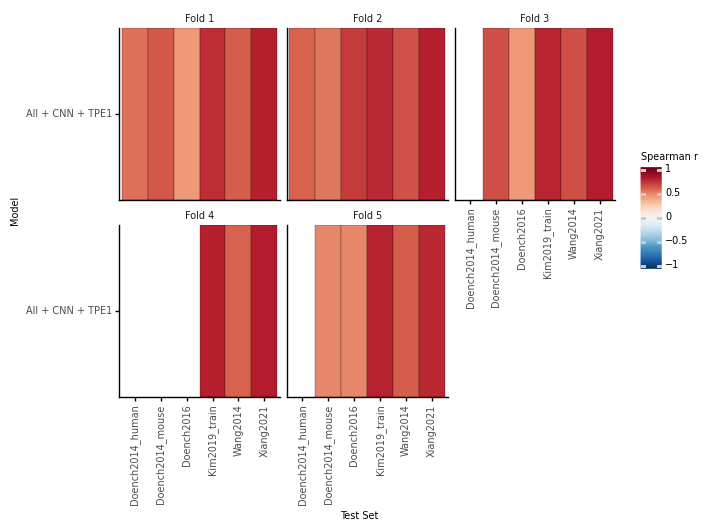

<ggplot: (8753929187385)>

In [14]:
plot_spearman_heatmap(cnn_predictive_performance)

/opt/conda/lib/python3.7/site-packages/plotnine/geoms/geom_point.py:70: UserWarning: You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/conda/lib/python3.7/site-packages/plotnine/geoms/geom_point.py:70: UserWarning: You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/conda/lib/python3.7/site-packages/plotnine/geoms/geom_point.py:70: UserWarning: You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/conda/lib/python3.7/site-packages/plotnine/geoms/geom_point.py:70: UserWarning: You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignorin

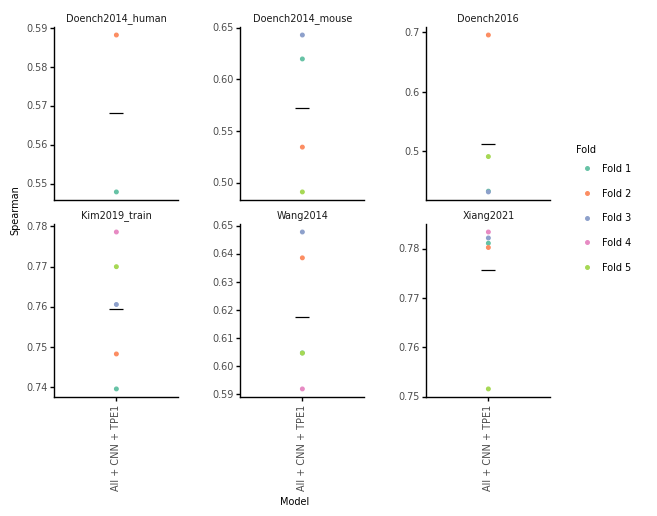

<ggplot: (8753987228977)>

In [15]:
plot_model_performance(cnn_predictive_performance, wspace=0.5)

## **Remember to download the predictive performance dataframe, as the local store is not permanent**


In [16]:
cnn_predictive_performance

,model_name,testing_set,fold,spearman_r,n_guides,fold_name
0,All + CNN + TPE1,Doench2014_human,0,0.547845,167,Fold 1
1,All + CNN + TPE1,Doench2014_human,1,0.588189,828,Fold 2
2,All + CNN + TPE1,Doench2014_mouse,0,0.619695,354,Fold 1
3,All + CNN + TPE1,Doench2014_mouse,1,0.534414,485,Fold 2
4,All + CNN + TPE1,Doench2014_mouse,2,0.642843,79,Fold 3
5,All + CNN + TPE1,Doench2014_mouse,4,0.491053,251,Fold 5
6,All + CNN + TPE1,Doench2016,0,0.432932,924,Fold 1
7,All + CNN + TPE1,Doench2016,1,0.695661,63,Fold 2
8,All + CNN + TPE1,Doench2016,2,0.431625,1245,Fold 3
9,All + CNN + TPE1,Doench2016,4,0.491129,304,Fold 5


In [17]:
cnn_predictions = pd.concat(cnn_prediction_list)

In [18]:
cnn_predictions.to_csv('../data/processed/seq_cnn_predictions.csv', index=False)